## Settings

In [1]:
%matplotlib inline
from pathlib import Path
import importlib
from functools import partial

from skimage import color
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns
from bruno_util import plotting as bplt
import scipy
import scipy.stats
from PIL import Image

import multi_locus_analysis as mla
import multi_locus_analysis.examples.burgess as burgess
import multi_locus_analysis.examples.burgess.plotting as mplt
from multi_locus_analysis.examples.burgess.styles import *

use_pnas_style()

from wlcsim.analytical import rouse
from wlcsim.analytical import homolog

In [28]:
import matplotlib.font_manager

In [ ]:
matplotlib.font_manager._rebuild()

In [29]:
matplotlib.font_manager.fontManager = matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [30]:
'Fira' in matplotlib.font_manager.findfont('Fira Sans')

True

### Output settings


In [2]:
output_folder = (Path(mla.__file__).parent / Path('../doc/source/_static/homologs/')).resolve()

get font sizes to use in Inkscape

In [3]:
plt.plot()
xl = plt.xlabel('test')
titl = plt.title('test')
print("Label font size: " + str(xl.get_font_properties().get_size_in_points()) + "pts")
print("Title font size: " + str(titl.get_font_properties().get_size_in_points()) + "pts")
plt.close()

Label font size: 8.0pts
Title font size: 9.6pts


In [4]:
mpl.rcParams['figure.figsize']

[3.405, 2.104405731693392]

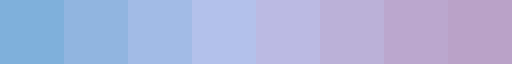

In [2]:
sim_listed_cmap

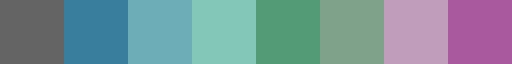

In [3]:
long_listed_cmap

### Functions used in multiple plots

In [4]:
def plot_fracs_small(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 4  # if strain == 'LYS2' else 4
            markeredgewidth = 1.5 if strain == 'LYS2' else 1
            
            if ax is None:
                ax = plt
            genotype = genotype if genotype == 'WT' else r'$\textit{spo11}\Delta{}$'
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=1, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  
    
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 6  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            genotype = genotype if genotype == 'WT' else r'$\textit{spo11}\Delta{}$'

            if ax is None:
                ax = plt
            non_g0 = data[data['t'] >= 0]
            ax.errorbar(non_g0['t'], non_g0['mean'], non_g0['std']/np.sqrt(non_g0['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
            g0 = data[data['t'] < 0]
            ax.errorbar(g0['t'], g0['mean'], g0['std']/np.sqrt(g0['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker)
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  

## Figure 1

In [14]:
# ### PANEL A
# def fig1a(ax1a):
#     im = Image.open("extracted-progression-diagram.png")
#     ax1a.imshow(im)
#     ax1a.axis('off')
#     ax1a.text(0.270, 1, "Early", fontsize=mpl.rcParams['axes.titlesize'], color=color_early, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.577, 1, "Mid", fontsize=mpl.rcParams['axes.titlesize'], color=color_mid, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.892, 1, "Late", fontsize=mpl.rcParams['axes.titlesize'], color=color_late, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     return ax1a

### PANEL B

def fig1d(ax1d):
    # make background image with various colors
    color_list = cmap_long(long_cnorm_continuous(np.linspace(0, 5, 1000)))
    color_list[:,3] = 0.9 # alpha value
    background_img = np.tile(color_list, (2, 1, 1)).T.T

    # get data about meiotic progression extracted from Trent's figure
    df_trent = pd.read_csv('pnas_data/extracted-progression-data.csv')
    t04 = np.arange(0, 5)
    frac_nuc = df_trent['Unnamed: 1'].iloc[1:].values.astype(float)
    # Sean wanted these removed, we no longer talk about SC
#     t2p5 = np.arange(2.5, 5)
#     frac_sc = df_trent['Unnamed: 3'].iloc[1:4].values.astype(float)
    t35 = np.arange(3, 6)
    frac_mi = df_trent['Unnamed: 5'].iloc[1:4].values.astype(float)
    # make lines
    ax1d.plot(t04, frac_nuc/100, c='k', marker='o', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
#     ax1d.plot(t2p5, frac_sc/100, c='k', marker='X', markersize=8, markeredgewidth=1,
#              fillstyle='full', linestyle='-', lw=1.5, clip_on=False)
    ax1d.plot(t35, frac_mi/100, c='k', marker='s', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
    # make text overlay
    dna_rep_time = [0.3, 1.5]
    dna_rep_y = 0.78
    dna_rep_cap_width = 0.03
    dna_rep_cap_y = [dna_rep_y - dna_rep_cap_width, dna_rep_y + dna_rep_cap_width]
    ax1d.plot(dna_rep_time, [dna_rep_y, dna_rep_y], color='k', linestyle='-', lw=1.5)
    ax1d.plot([dna_rep_time[0], dna_rep_time[0]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
    ax1d.plot([dna_rep_time[1], dna_rep_time[1]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
#     ax1d.text(np.mean(dna_rep_time)+0.02, 0.84, 'DNA Replication', ha='center', va='bottom')
    ax1d.text(dna_rep_time[0]-0.02, 0.84, 'DNA Replication', ha='left', va='bottom')
    ax1d.text(2.4, 0.68, 'Colocalization', ha='center', va='top')
#     ax1d.text(2.7, 0.36, 'SC', ha='center', va='top')
    ax1d.text(3.62, 0.3, 'Meiosis I', ha='right', va='top')

    ax1d.imshow(background_img, extent=[0, 5, 0, 1], aspect='auto')
    ax1d.set_xlim([0, 5])
    ax1d.set_ylim([0, 1])
    ax1d.xaxis.set_major_formatter(long_formatter)
    ax1d.xaxis.set_major_locator(long_locator)

    ax1d.set_xlabel('Chronological stage')
    ax1d.set_ylabel('Probability')
    ax1d.set_title('Meiotic prophase')
    return ax1d


take out SC curve, add description stating that before t3, no division occurs.

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

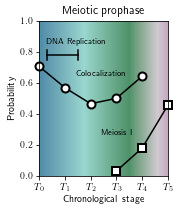

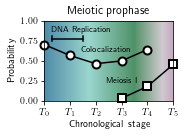

In [21]:
# this panel only gets part of the column, 2.305in measured in inkscape
fig1dh, fig1d_height = bplt.make_at_aspect([fig1d], [1/golden_ratio], col_width=2.305)
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig1d.pdf', dpi=500)
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig1d.svg', dpi=500)


## Figure 2

Made fully in Inkscape.... :/

In [22]:
from IPython.core.display import SVG
SVG(filename='./pnas_data/Fig2.svg')

## Figure 3

Made fully in Inkscape.... :/

In [23]:
from IPython.core.display import SVG
SVG(filename='./pnas_data/Fig3.svg')

## Figure 4

In [81]:
mu_fig4 = 4
N_cells_fig4 = 5
cells = np.array([
    homolog.generate_poisson_homologs(mu_fig4, burgess.chrv_size_effective_um) 
    for i in range(N_cells_fig4)
])
plateaus = [
    homolog.mscd_plateau(
        cell, 
        label_loc=burgess.location_ura_effective_um, 
        chr_size=burgess.chrv_size_effective_um, 
        nuc_radius=burgess.nuc_radius_um,
        b=burgess.kuhn_length_nuc_chain
    ) for cell in cells
]
i = np.argsort(plateaus)
cells = cells[i]
cells

<ipython-input-81-dfb55f6d87cb>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cells = np.array([


array([array([1.35451938, 4.12494403, 8.08643863, 8.4612453 ]),
       array([ 0.70020429,  4.24474321,  4.85810796,  4.96864306,  7.07399572,
       11.20764539]),
       array([ 0.87904695,  4.97715212, 11.76368115, 13.10283368, 15.66165474]),
       array([ 7.15019895,  8.1517839 ,  8.58259736, 10.83326371]),
       array([ 7.7002465 , 12.92765367, 14.64904821])], dtype=object)

In [96]:
importlib.reload(mplt)

<module 'multi_locus_analysis.examples.burgess.plotting' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/examples/burgess/plotting.py'>

[Text(0, 0.2, '$2\\times{}10^{-1}$'),
 Text(0, 0.3, ''),
 Text(0, 0.4, ''),
 Text(0, 0.5, ''),
 Text(0, 0.6, ''),
 Text(0, 0.7, ''),
 Text(0, 0.8, ''),
 Text(0, 0.9, ''),
 Text(0, 1.0, '$10^0$'),
 Text(0, 2.0, ''),
 Text(0, 3.0, '$3\\times{}10^0$')]

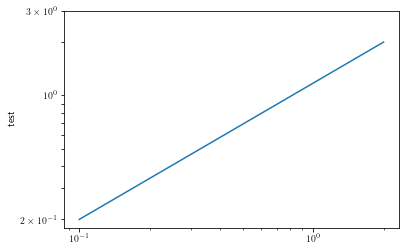

In [103]:
fig, ax = plt.subplots()
ax.loglog([.1, 2], [.2, 2])
text = plt.ylabel('test')
ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3.])
ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", r"$3\times{}10^0$"])
 

In [104]:
text.get_position()

(15.701459979179639, 0.5)

In [97]:
def fig4a(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.title('Per-Cell MSCDs for Condition: (URA3, WT, t3)')
    ax.set_prop_cycle(color=['#aec7e8'])
    cell_ids = []
    for i, (cell_id, data) in enumerate(free_mscds3.groupby(['exp.rep', 'cell'])):
    #     if i not in [10, 25, 30, 60]: # 60 is flat
        if i % 20 != 0:
                continue
        cell_ids.append(cell_id)
        data = data.reset_index()
        data = data[(data['delta'] > 0) & (data['mean'] > 0)]
        data = data.sort_values('delta')
    #     plt.errorbar(data['delta'], data['mean'], data['ste'])
        if cell_id == (5, 56):
            ax.plot(data['delta'], data['mean'], '-', c='#1f77b4', lw=5, zorder=3)
        else:
            ax.plot(data['delta'], data['mean'], alpha=1, lw=1)
            ax.plot(data['delta'], data['mean'], alpha=0.3, lw=3)
    bplt.draw_power_law_triangle(ax=ax, alpha=0, x0=[30, 1.05], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
    bplt.draw_power_law_triangle(ax=ax, alpha=0.5, x0=[225, 0.37], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0.5$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
#     ax.set_ylim([0.2, 2.05])
    ax.set_ylim([0.2, 3])    
    ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3.])
    ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", r"$3\times{}10^0$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

def fig4b(ax):
    t = np.logspace(1, 4, 50).astype(float)
    for i, linkages in enumerate(cells):
        mscd = homolog.mscd(
            t, linkages, 
            label_loc=burgess.location_ura_effective_um, 
            chr_size=burgess.chrv_size_effective_um, 
            nuc_radius=burgess.nuc_radius_um,
            b=burgess.kuhn_length_nuc_chain, 
            D=burgess.D
        )
        lines = ax.loglog(t, mscd, c=cycling_cmap.colors[i])
        ax.annotate('Cell ' + str(i), [t[-1], mscd[-1]], va='bottom', ha='right', 
                    c=cycling_cmap.colors[i], fontsize=mpl.rcParams['axes.titlesize'])
#     ax.set_xlim([10, 10**4])
    ax.set_ylim([0.02, 1])    
#     ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3., 4.])
#     ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", "", r"$4\times{}10^0$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)') #, labelpad=-float(mpl.rcParams['font.size']))
    
    return ax

def fig4c(ax):
    return mplt.draw_cells(
        cells, ax=ax, 
        label_loc=burgess.location_ura_effective_um,
        cen_loc=burgess.location_cen5_effective_um,
        chr_size=burgess.chrv_size_effective_um,
        label_colors=cycling_cmap.colors[:len(cells)]
    )

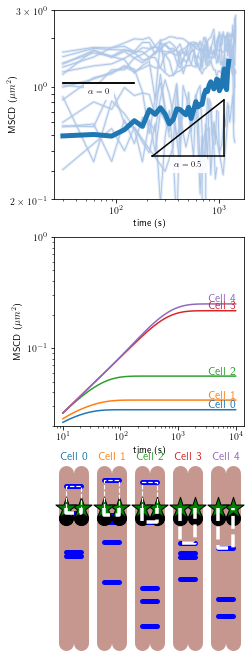

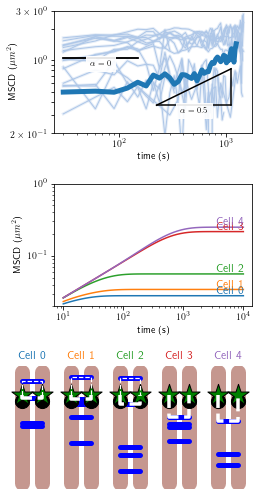

In [98]:
free_group3 = burgess.df_flat.loc['URA3', 'WT', :, 't3'].copy()

free_mscds3 = burgess.msds.msd(free_group3[free_group3['foci'] == 'unp'], mscd=True, include_z=True, 
                              traj_group=['exp.rep', 'cell'],
                              groups=['exp.rep', 'cell'])
fig4, fig4_heights = bplt.make_at_aspect(
    [fig4a, fig4b, fig4c], [1/golden_ratio, 1/golden_ratio, 1/2], col_width, 
    tight_width='bbox', halign=['min_axis_width', 'min_axis_width', 'full'], 
    hspace=0.15, is_ratio=True)

# plt.savefig("/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig4.pdf")
plt.savefig(output_folder / Path('Fig4.svg'))

## Figure 5

after running the following, they must still be assembled in inkscape and the labels of the arrows must still be added (by copying over the appropriate colorbar tick labels to label the arrows with)

### Fitting Diffusivity

In [85]:
msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
mscds = pd.read_csv(msds_file) \
        .set_index(['locus', 'genotype', 'meiosis'])
mscd_ura_t3 = mscds.loc['URA3', 'WT', 't3'].sort_values('delta')
plateau = plateaus[('URA3', 'WT')]['t3']
mu = fit_mus[('URA3', 'WT')]['t3']
t_data = burgess.t_data[:-1]  # mscd 'delta' only up to 1470
def compare_to_ura3(logD, N_cells=1000):
    D = 10**logD
    theory_mscds = np.zeros_like(t_data)
    for j in range(N_cells):
        theory_mscds += (1/N_cells) * homolog.mscd(
            t_data,
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um),
            label_loc=burgess.location_ura_nuc_chain_um,
            chr_size=burgess.chrv_size_nuc_chain_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
            D=D*np.random.exponential()
        )
    theory_mscds = theory_mscds/theory_mscds[-1]*plateau
    return -np.linalg.norm(theory_mscds - mscd_ura_t3['mean'])

In [86]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'logD': (-1, 1)}

optimizer = BayesianOptimization(
    f=compare_to_ura3,
    pbounds=pbounds,
    random_state=1,
)

In [87]:
optimizer.maximize(
    init_points=5,
    n_iter=5,
)

|   iter    |  target   |   logD    |
-------------------------------------
|  1        | -1.037    | -0.166    |
|  2        | -0.2697   |  0.4406   |
|  3        | -2.553    | -0.9998   |
|  4        | -1.413    | -0.3953   |
|  5        | -1.998    | -0.7065   |
|  6        | -0.2477   |  1.0      |
|  7        | -0.1558   |  0.7346   |
|  8        | -0.165    |  0.6707   |
|  9        | -0.1873   |  0.7827   |
|  10       | -0.4424   |  0.215    |


In [88]:
def plot_bayes_opt(f, optimizer):
    x = np.linspace(-1, 1, 1000)
    mean, sigma = optimizer._gp.predict(x.reshape(-1, 1), return_std=True)
    plt.plot(10**x, mean)
    plt.fill_between(10**x, mean + sigma, mean - sigma, alpha=0.1)
    plt.scatter(10**optimizer.space.params.flatten(), optimizer.space.target, c="red", s=50, zorder=10)
    plt.xlabel('D ($\mu{}m^2$)')
    plt.ylabel('$-||$ Theory -- Experiment $||^2$')

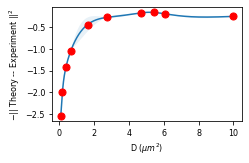

In [89]:
plot_bayes_opt(compare_to_ura3, optimizer)
plt.savefig('./_static/homologs/SuppFig_D-fit_a.svg')

In [ ]:
optimizer.set_bounds(new_bounds={'logD': [np.log10(2), np.log10(8)]})
optimizer.maximize(n_iter=100)

|   iter    |  target   |   logD    |
-------------------------------------


In [103]:
N_cells = 1000
D = burgess.sim_D
theory_mscds = np.zeros_like(t_data)
for j in range(N_cells):
    theory_mscds += (1/N_cells) * homolog.mscd(
        t_data,
        homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um),
        label_loc=burgess.location_ura_nuc_chain_um,
        chr_size=burgess.chrv_size_nuc_chain_um,
        nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
        D=D*np.random.exponential()
    )
theory_mscds = theory_mscds/theory_mscds[-1]*plateau

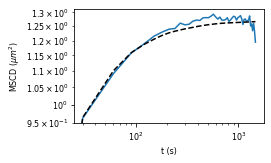

In [105]:
plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
plt.loglog(t_data, theory_mscds, 'k--')
plt.xlabel('t (s)')
plt.ylabel('MSCD ($\mu{}m^2$)')
plt.savefig('./_static/homologs/SuppFig_D-fit_b.svg')

### Actually making the plots

In [67]:
ymax = 1.5

def fig5ac(ax, strain=('URA3', 'WT'), arrows=True):
    msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
    if not msds_file.exists():
        burgess.msds.precompute_msds()
    mscds = pd.read_csv(msds_file) \
            .set_index(['locus', 'genotype', 'meiosis'])

    d = mscds.loc[strain]

#     fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')

    ## draw all the MSCDs
    thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
    lines = {}
    for meiosis, data in d.groupby('meiosis'):
        t = -1 if meiosis[1] == 'a' else int(meiosis[1])
        data = data[data['delta'] > 0]
        zorder = 1.5 if t < 0 else 2  # 2 is default
        linewidth = 2 if t in thick_lines else 1
        alpha = 0.8 if t < 0 else 1
        lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
                                      c=long_listed_cmap(long_cnorm(t)), zorder=zorder,
                                      alpha=alpha, lw=linewidth)
    #     bplt.draw_power_law_triangle(alpha=0.2, x0=[100, 0.5], width=0.7, orientation='down', x0_logscale=False, label=r'$\alpha=0.2$', label_padding=0.02)
    ax.set_ylim([0.5, ymax])
    ax.set_xlim(ax.get_xlim())  # default is good, but needs stay fixed

    ## draw the two arrows
    if arrows:
        # in data coordinates
        x1, y1 = 30, 0.61
        x2, y2 = 50, 1
        # in axes coordinates, to avoid bad log scaling
        data_to_ax = ax.transData + ax.transAxes.inverted()
        X1_ax = data_to_ax.transform([x1, y1])
        X2_ax = data_to_ax.transform([x2, y2])
        dX21_ax = X2_ax - X1_ax
        ax.arrow(*X1_ax, *dX21_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)
        X3_ax = X2_ax + np.array([0.05, 0.05])
        x4, y4 = 84, 0.9
        X4_ax = data_to_ax.transform([x4, y4])
        X4_ax_alt = X3_ax + dX21_ax*np.array([1, -1])  # to get same x offset
        dX43_ax = X4_ax - X3_ax
        ax.arrow(*X3_ax, *dX43_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)

    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    # plt.savefig("/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-01-28-proposed/mscd-" + str(strain) + "-with-cbar-short.pdf")


    ## ticks, labels, etc
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ymax])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", f"${ymax}" + r"\times{}10^{0}$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

def fig5b(ax):
    mus = np.arange(7)
    t = np.arange(0, 1500, 30)
    N_cells = 1000
    for mu in mus:
        mscd = np.zeros_like(t)
        for i in range(N_cells):
            mscd += (1/N_cells) * model_mscd(t, generate_example_cell(mu), nuc_radius=1.3)
        plt.loglog(t, mscd, c=sim_cnorm(sim_listed_cmap(mu)))
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    cb.set_label('Connections per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10, 10**4])
    ax.set_ylim([0.5, 1.5])    
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ymax])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", f"${ymax}" + r"\times{}10^{0}$"])
#     ax.set_ylim([0.2, 3.5])
#     ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3.])
#     ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", ""])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

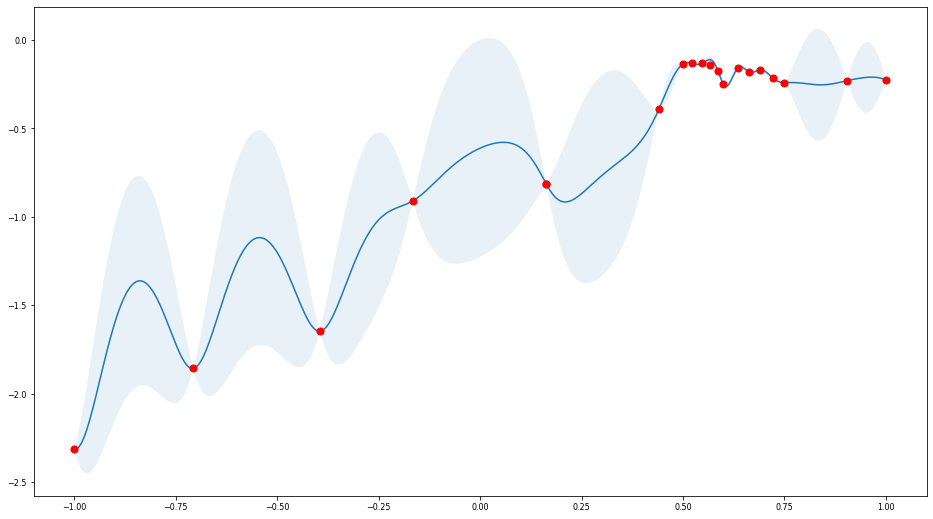

In [61]:
plot_bayes_opt(compare_to_ura3, optimizer)

In [62]:
optimizer.set_bounds(new_bounds={'logD': [0.4, 0.6]})
optimizer.maximize(
    init_points=5,
    n_iter=5,
)

|   iter    |  target   |   logD    |
-------------------------------------
|  21       | -0.2238   |  0.4838   |
|  22       | -0.1486   |  0.537    |
|  23       | -0.2712   |  0.4409   |
|  24       | -0.2372   |  0.5756   |
|  25       | -0.3245   |  0.4055   |
|  26       | -0.2692   |  0.444    |
|  27       | -0.1219   |  0.5425   |
|  28       | -0.2419   |  0.5696   |
|  29       | -0.2531   |  0.5269   |
|  30       | -0.2056   |  0.4961   |


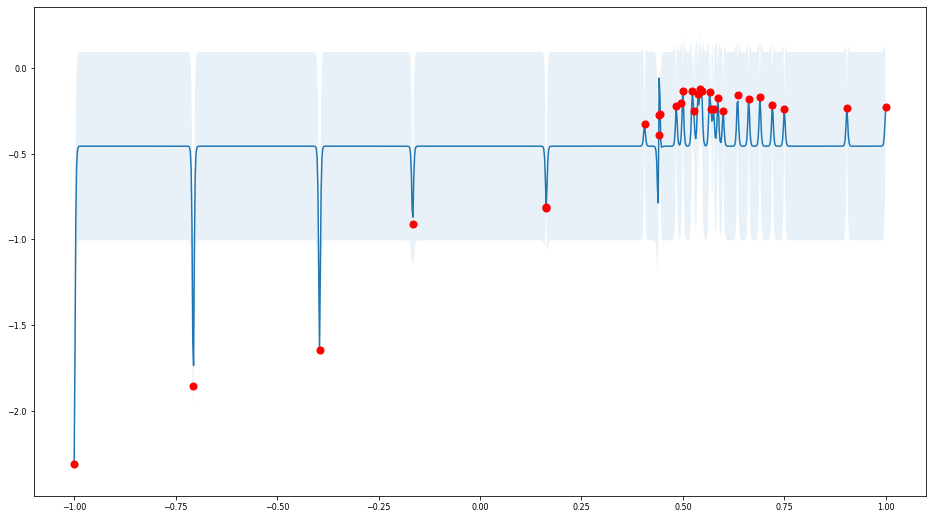

In [63]:
plot_bayes_opt(compare_to_ura3, optimizer)

In [64]:
optimizer.max

{'target': -0.12190306508899447, 'params': {'logD': 0.5424883981145125}}

make two plots: 
1) as is, data
2) chronological stage vs num-linkages fit

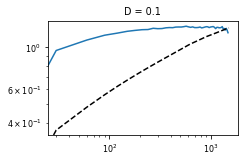

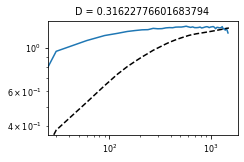

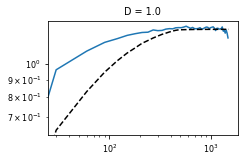

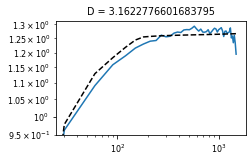

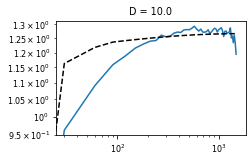

In [41]:
test_Ds = np.logspace(-1, 1, 5)
plateau = plateaus[('URA3', 'WT')]['t3']
mu = fit_mus[('URA3', 'WT')]['t3']
N_cells = 100
for D in test_Ds:
    theory_mscds = np.zeros_like(burgess.t_data)
    for j in range(N_cells):
        theory_mscds += (1/N_cells) * homolog.mscd(
            burgess.t_data,
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um),
            label_loc=burgess.location_ura_nuc_chain_um,
            chr_size=burgess.chrv_size_nuc_chain_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
            D=D*np.random.exponential()
        )
    plt.figure()
    plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
    plt.loglog(burgess.t_data, theory_mscds/theory_mscds[-1]*plateau, 'k--')
    plt.title(f'D = {D}')

In [134]:
import noisyopt

In [112]:
theory_mscds[-1]

0.4312893362994077

In [111]:
np.interp(mu, mus, plateau_observed)

1.2661445372125406

Text(0.5, 1.0, 'D = 10.0')

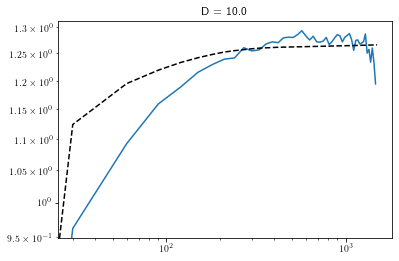

In [113]:
nominal_plateau = np.interp(mu, mus, plateau_observed)
plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
plt.loglog(t_data, theory_mscds*nominal_plateau/theory_mscds[-1], 'k--')
plt.title(f'D = {D}')

In [57]:
msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
mscds = pd.read_csv(msds_file) \
        .set_index(['locus', 'genotype', 'meiosis'])
mscd_ura_t3 = mscds.loc['URA3', 'WT', 't3']

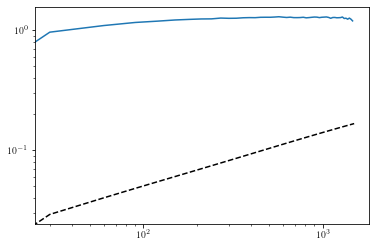

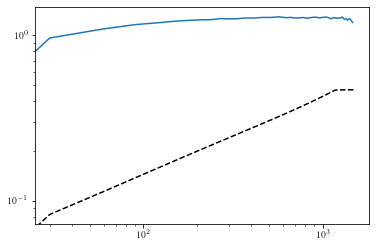

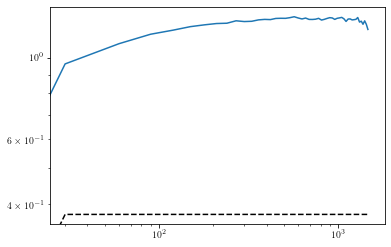

In [68]:
test_Ds = np.logspace(-2, 1, 4)
N_cells = 100
for D in test_Ds:
    theory_mscds = np.zeros_like(t_data)
    mu = fit_mus[('URA3', 'WT')]['t3']
    for j in range(N_cells):
        theory_mscds += (1/N_cells) * homolog.mscd(
            t_data,
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_effective_um),
            label_loc=burgess.location_ura_effective_um,
            chr_size=burgess.chrv_size_effective_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
            D=D
        )
    plt.figure()
    plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
    plt.loglog(t_data, theory_mscds, 'k--')

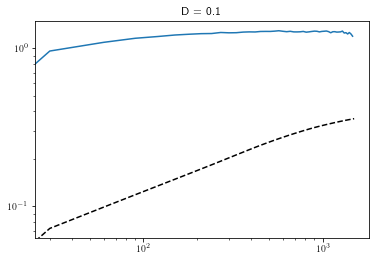

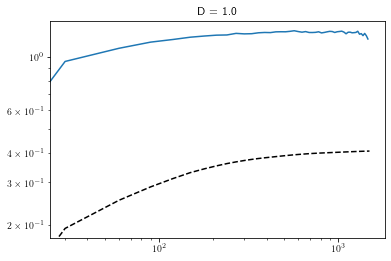

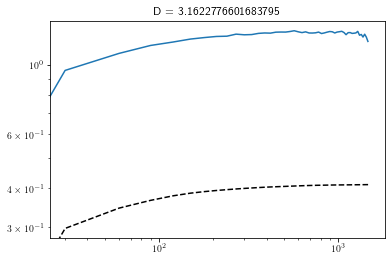

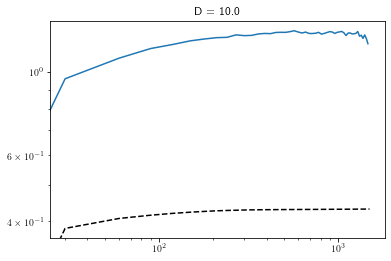

In [105]:
test_Ds = np.logspace(-1, 1, 5)
N_cells = 1000
for D in test_Ds:
    theory_mscds = np.zeros_like(t_data)
    mu = fit_mus[('URA3', 'WT')]['t3']
    for j in range(N_cells):
        theory_mscds += (1/N_cells) * homolog.mscd(
            t_data,
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_effective_um),
            label_loc=burgess.location_ura_effective_um,
            chr_size=burgess.chrv_size_effective_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
            D=D*np.random.exponential()
        )
    plt.figure()
    plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
    plt.loglog(t_data, theory_mscds, 'k--')
    plt.title(f'D = {D}')

In [134]:
import noisyopt

In [112]:
theory_mscds[-1]

0.4312893362994077

In [111]:
np.interp(mu, mus, plateau_observed)

1.2661445372125406

Text(0.5, 1.0, 'D = 10.0')

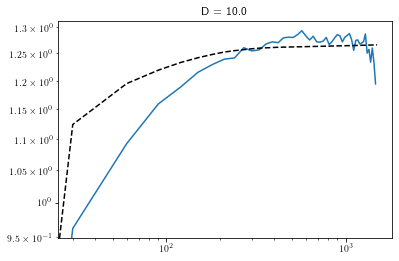

In [113]:
nominal_plateau = np.interp(mu, mus, plateau_observed)
plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
plt.loglog(t_data, theory_mscds*nominal_plateau/theory_mscds[-1], 'k--')
plt.title(f'D = {D}')

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

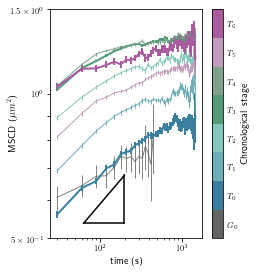

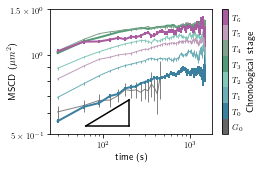

In [37]:
# # twin version rejected by Sean
# def fig4d_twin(ax):
#     wt = plateaus[(locus, 'WT')]
#     sp = plateaus[(locus, 'SP')]
#     ax.plot(np.arange(len(wt)), wt.values, c=cycling_cmap(1))
#     ax.plot(np.arange(len(sp)), sp.values, c=cycling_cmap(0))
#     ax.set_xlabel('Chronological stage')
#     ax.set_ylim([0.5, 2])
#     ax2 = ax.twiny()
#     ax2.plot(andy_links, andy_plats, c='k')
#     ax2.set_xlabel('Number of linkages')
#     ax2.set_xlim([1, 5])
def fig5c_with_triangle(ax):
    fig5ac(ax, strain=('URA3', 'SP'), arrows=False)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.27), 0.5, orientation='down', ax=ax, label=None)
    return ax
    
bplt.make_at_aspect(
        [fig5c_with_triangle], 
        [1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['min_axis_width', 'min_axis_width'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig5c.svg')

In [ ]:
def fig5a_with_triangle(ax):
    fig5ac(ax, strain=('URA3', 'WT'))
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
def fig5b_with_triangle(ax):    
    fig5b(ax)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
bplt.make_at_aspect(
        [fig5a_with_triangle, fig5b_with_triangle], 
        [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig5ab.svg')

/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:122: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ti = t[:,None] - np.zeros_like(t)[None,:]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:123: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tf = t[None,:] - np.zeros_like(t)[:,None]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:129: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  vs = {'v' + col: x[None,:] - x[:,None] for col, x in xs.items()}


In [133]:
def fig5d(ax):
    fit_mus['cell_count'] = np.nan
    plot_fracs_large(fit_mus, ax)
    ax.set_ylabel('Average linkages per chromosome')
    ax.legend(fontsize='small')
    return ax

In [131]:
fit_mus

level_0  level_1         0
0          0  level_0         0
1          0  level_1   level_0
2          0        0        t0
3          1  level_0         0
4          1  level_1   level_1
..       ...      ...       ...
151       50  level_1         0
152       50        0   1.71042
153       51  level_0        12
154       51  level_1  genotype
155       51        0      URA3

[156 rows x 3 columns]

In [130]:
fit_mus = fit_mus.stack().reset_index()
fit_mus['locus'] = fit_mus['level_1'].apply(lambda x: x[0])
fit_mus['genotype'] = fit_mus['level_1'].apply(lambda x: x[1])
fit_mus['meiosis'] = fit_mus['level_0']
fit_mus['mu'] = fit_mus['0']

TypeError: 'int' object is not subscriptable

## Figure 6

In [122]:
pair_fracs = (burgess.df_flat['foci'] == 'pair').groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
cells_per_state = burgess.df_flat.reset_index().groupby(burgess.condition_cols)['cell'].unique().apply(len)
pair_fracs['cell_count'] = cells_per_state

In [44]:
np.linalg.norm(theory_mscds[:-1]/theory_mscds[-1]*plateau - mscd_ura_t3['mean'])

0.285712693423104

In [124]:
pair_fracs

mean       std  count  cell_count
locus genotype meiosis                                       
HET5  WT       t0       0.412258  0.492273   7750         100
               t1       0.319586  0.466348   7250          84
               t2       0.196377  0.397286   6900          92
               t3       0.172886  0.378174   7450          93
               t4       0.153710  0.360699   6200          93
               t5       0.146809  0.353953   4700          68
               ta       0.165672  0.371841   3350          67
LYS2  SP       t0       0.707168  0.455078  13950         114
               t1       0.715968  0.450970  12400         122
               t2       0.509723  0.499925  12650         109
               t3       0.403012  0.490533   8300          93
               t4       0.308736  0.461993  10692          81
               t5       0.272753  0.445407   7010          80
               t6       0.290000  0.453937   1300          26
      WT       t0       0.540933  0.498355   7500          83
               t1       0.597927  0.490347   8006          88
               t2       0.416104  0.492935  10370          90
               t3       0.454149  0.497923   8484          77
               t4       0.615743  0.486464   5361          83
               t5       0.652400  0.476256   5000          65
               t6       0.693237  0.461243   2484          69
URA3  SP       t0       0.621639  0.484997  12755         108
               t1       0.517453  0.499709  17791         106
               t2       0.383030  0.486150   9900          98
               t3       0.259673  0.438468  16309         100
               t4       0.204320  0.403218  13983          85
               t5       0.289291  0.453451  12700          87
               t6       0.217200  0.412422   2500          50
               ta       0.745625  0.435645   1600         100
      WT       t0       0.638022  0.480586  18200         129
               t1       0.530071  0.499109  17658         118
               t2       0.438462  0.496216  14300         100
               t3       0.461605  0.498538  17216          95
               t4       0.603117  0.489268  14760          97
               t5       0.580000  0.493586   9000          64
               ta       0.772874  0.418999   8678         127

In [42]:
mscd_ura_t3['delta']

locus  genotype  meiosis
URA3   WT        t3            0
                 t3           30
                 t3           60
                 t3           90
                 t3          120
                 t3          150
                 t3          180
                 t3          210
                 t3          240
                 t3          270
                 t3          300
                 t3          330
                 t3          360
                 t3          390
                 t3          420
                 t3          450
                 t3          480
                 t3          510
                 t3          540
                 t3          570
                 t3          600
                 t3          630
                 t3          660
                 t3          690
                 t3          720
                 t3          750
                 t3          780
                 t3          810
                 t3          840
                 t

In [119]:
def fig6a(ax):
    pair_fracs = (df_flat['foci'] == 'pair').groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
    cells_per_state = df_flat.reset_index().groupby(condition_cols)['cell'].unique().apply(len)
    pair_fracs['cell_count'] = cells_per_state
    plot_fracs_large(pair_fracs, ax)
    ax.set_ylabel('Fraction always colocalized')
    ax.legend(fontsize='small')
    return ax
  
def fig6b(ax):
    is_mixed = df_flat['foci'].groupby(burgess.cell_cols).apply(lambda x: np.any(x == 'pair') and np.any(x == 'unp'))
    mixed_fracs = is_mixed.groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
    cells_per_state = df_flat.reset_index().groupby(condition_cols)['cell'].unique().apply(len)
    mixed_fracs['cell_count'] = cells_per_state
    mixed_fracs['ste'] = mixed_fracs['std']/np.sqrt(mixed_fracs['cell_count'])
    plot_fracs_large(mixed_fracs, ax)
    ax.legend(fontsize='small')
    ax.set_ylabel('Fraction mixed')
    ax.set_ylim([0.15, 0.95])
    return ax
    
    

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

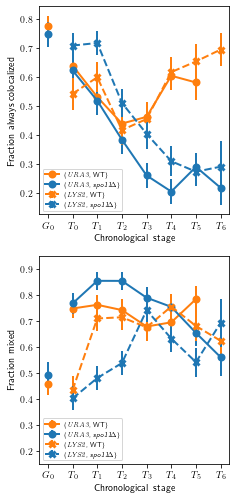

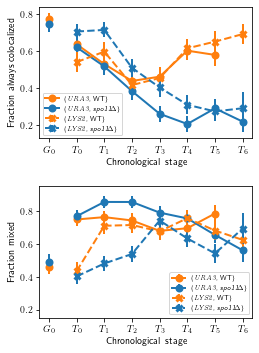

In [13]:
fig6ab, fig6ab_heights = bplt.make_at_aspect([fig6a, fig6b], [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'min_axis_width'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig6ab.svg')
plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig6ab.pdf')

## Figure 7

TODO: fix line coloring and ordering, currently done in inkscape...

In [14]:
sim_df = pd.read_csv(Path('pnas_data/df_exp.csv'))
sim_df['t'] = np.round(sim_df['t']/30).astype(int)*30
for x in ['X', 'Y', 'Z']:
    sim_df['d'+x] = sim_df[x+'2'] - sim_df[x+'1']
wait_sim = burgess.simulation.get_interior_times(sim_df)
wait_sim = wait_sim.reset_index()
# wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < 0.2)]
wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < vmax_sim)]

waitdf = df_flat.groupby(burgess.cell_cols + ['na_id']).apply(mla.finite_window.discrete_trajectory_to_wait_times, t_col='t', state_col='foci')
waitdf.dropna(inplace=True) # get rid of NaN waits (currently buggy window sizes)
interior_df = waitdf.groupby(burgess.cell_cols + ['na_id']).apply(
    lambda df: df.iloc[1:-1].reset_index(level='rank_order').reset_index(drop=True).set_index('rank_order'))
interior_df.sort_index(inplace=True)
pair_df = interior_df[interior_df['wait_state'] == 'pair']
unpair_df = interior_df[interior_df['wait_state'] == 'unp']

In [28]:
def fig7cdef(ax, strain=('LYS2', 'WT'), pair='pair'):
    df = pair_df if pair == 'pair' else unpair_df
    state_waits = df.loc[strain]
    bold_lines = [0, 6] if 't6' in state_waits.reset_index()['meiosis'] else [0, 5]
    print(bold_lines)
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t in bold_lines:
            continue
        alpha = 0.5
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, alpha=alpha)
    # make sure bold lines are on top
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t not in bold_lines:
            continue
        print(f'found bold line: {m}')
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, lw=2)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    ax.set_yscale('log')
    ax.set_xscale('log')
    pair = 'Residence times' if pair == 'pair' else 'Search times'
    strain = 'wild-type' if strain[1] == 'WT' else r'\textit{spo11$\Delta$}'
    ax.set_title(f"{pair}, {strain} PDFs")
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    return ax

def fig7a(ax):
    fp_targets = np.linspace(0.01, 0.02, 5)
    
    # some convenience variables
    paired_sim = wait_sim[wait_sim['wait_state']]
    paired_1 = paired_sim[paired_sim['FP'] == 0.01]
    paired_2 = paired_sim[paired_sim['FP'] == 0.02]
    unpaired_sim = wait_sim[~wait_sim['wait_state']]
    unpaired_1 = unpaired_sim[unpaired_sim['FP'] == 0.01]
    unpaired_2 = unpaired_sim[unpaired_sim['FP'] == 0.02]

    boot_N = 400
    fp01_options = paired_1.sim_name.unique()
    fp02_options = paired_2.sim_name.unique()

    paired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    unpaired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    for fp in fp_targets:
        frac_02 = (fp - 0.01)/(0.02 - 0.01)
        for i in range(boot_N):
            if np.random.rand() < frac_02:
                traj_name = np.random.choice(fp02_options)
                pwaits = paired_2[paired_2['sim_name'] == traj_name]
                upwaits = unpaired_2[unpaired_2['sim_name'] == traj_name]
            else:
                traj_name = np.random.choice(fp01_options)
                pwaits = paired_1[paired_1['sim_name'] == traj_name]
                upwaits = unpaired_1[unpaired_1['sim_name'] == traj_name]
            paired_waits[fp] = paired_waits[fp].append(pwaits)
            unpaired_waits[fp] = unpaired_waits[fp].append(upwaits)

    # bootstrapped ones
    for FP, paired in paired_waits.items():
        if FP > vmax_sim:
            continue
        if FP == 0.01:
            continue
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP))
    # true simulations
    for FP, data in wait_sim.groupby('FP'):
        if FP in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):
        if FP not in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    # plt.legend()
    ax.set_title('Residence times, simulation PDFs')
#     ax.set_ylim([2e-6, 4e-2])
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])

    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

def fig7b(ax):
    for FP, data in wait_sim.groupby('FP'):       
        if FP in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):        
        if FP not in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    # plt.legend()
    ax.set_title('Search time, simulation PDFs')
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

new arrangement, pretty voluminous

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


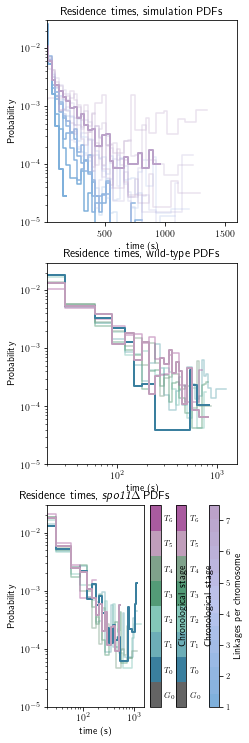

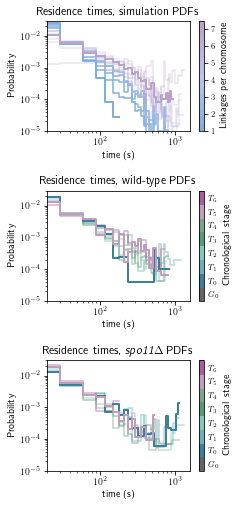

In [25]:
fig5ace, fig5ace_heights = bplt.make_at_aspect(
    [fig5c,
     partial(fig5abcd, strain=('LYS2', 'WT'), pair='pair'), 
     partial(fig5abcd, strain=('LYS2', 'SP'), pair='pair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
fig5ace.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig7ace.svg', dpi=300)

# fig5ace.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/Figure5ace-usetex.svg')

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


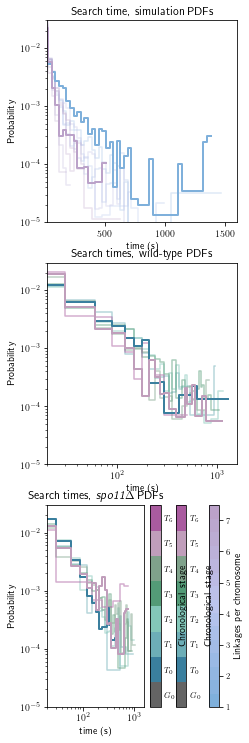

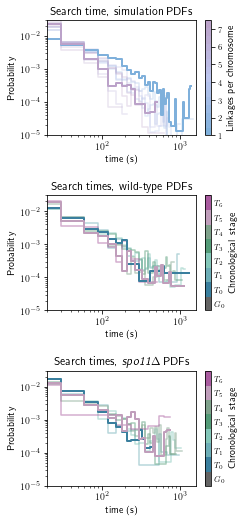

In [26]:
fig5bdf, fig5bdf_heights = bplt.make_at_aspect(
    [fig5f,
     partial(fig5abcd, strain=('LYS2', 'WT'), pair='unpair'), 
     partial(fig5abcd, strain=('LYS2', 'SP'), pair='unpair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
fig5bdf.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig7bdf.svg', dpi=300)

they're coming out slightly different sizes, let's do it all at once.

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:263: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


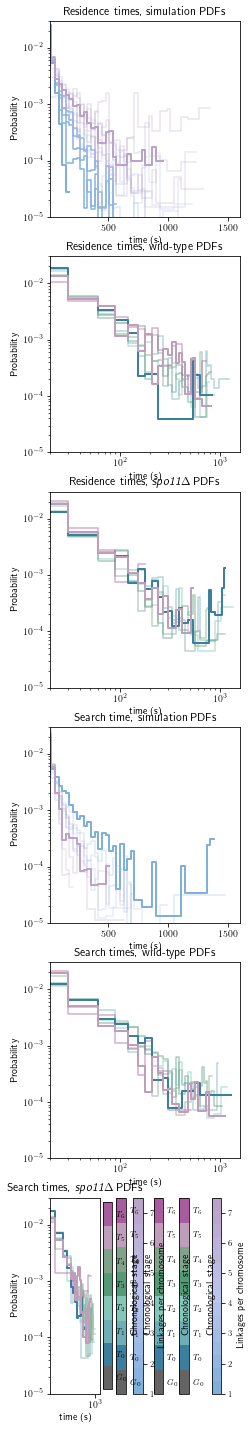

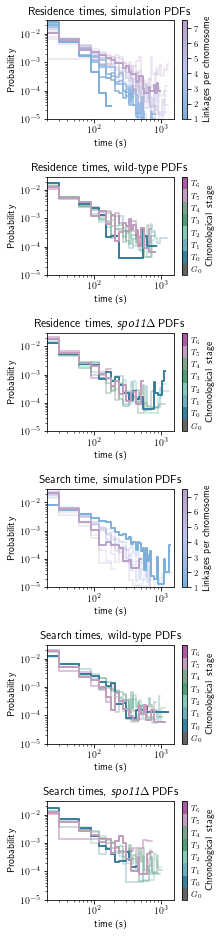

In [31]:
fig7acebdf, fig7acebdf_heights = bplt.make_at_aspect(
    [fig7a,
     partial(fig7cdef, strain=('LYS2', 'WT'), pair='pair'), 
     partial(fig7cdef, strain=('LYS2', 'SP'), pair='pair'),
     fig7b,
     partial(fig7cdef, strain=('LYS2', 'WT'), pair='unpair'), 
     partial(fig7cdef, strain=('LYS2', 'SP'), pair='unpair')],
    6*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=6*['min_axis_width'],
    is_ratio=True
)
fig7acebdf.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig7acebdf.svg', dpi=300)

## Supplemental Figure XX

## Supplemental Figure YY

In [34]:
xxburgess.chrv_size_wlc_um

196.13716

In [35]:
burgess.chrv_size_nuc_chain_um

17.474999999999998

## Supplemental Figure -- Convex Hull of Traj

In [16]:
import multi_locus_analysis.stats

In [18]:
from multi_locus_analysis.stats import convex_hull

In [19]:
chull_volume = burgess.df.groupby(burgess.cell_cols).apply(convex_hull, xcol='X', ycol='Y', zcol='Z', volume=True)

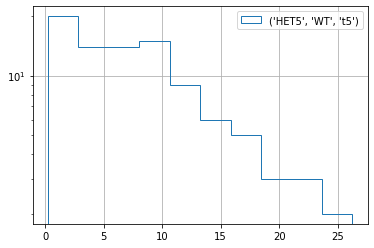

In [20]:
for condition, data in chull_volume.groupby(burgess.condition_cols):
    if condition == ('HET5', 'WT', 't5'):
        data.hist(label=str(condition), histtype='step')
        break
plt.legend()
plt.yscale('log')

In [21]:
def get_chull_volume(df):
    points = df[['X', 'Y', 'Z']].dropna().to_numpy()
    if len(points) == 0:
        return np.nan
    return scipy.spatial.ConvexHull(points).volume
chull_volume = burgess.df.groupby(burgess.cell_cols).apply(get_chull_volume)

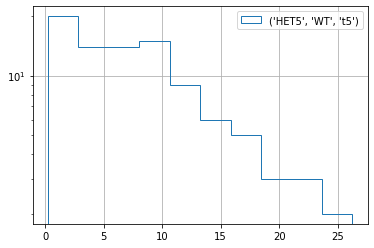

In [22]:
for condition, data in chull_volume.groupby(burgess.condition_cols):
    if condition == ('HET5', 'WT', 't5'):
        data.hist(label=str(condition), histtype='step')
        break
plt.legend()
plt.yscale('log')

In [24]:
chull_volume.loc['HET5', 'WT', :, 't5']

locus  genotype  exp.rep  meiosis  cell
HET5   WT        2        t5       1        7.497403
                                   2       10.503919
                                   3        3.065773
                                   4        4.135349
                                   7       14.163736
                                             ...    
                 3        t5       56       5.942666
                                   57       2.879856
                                   59      21.184126
                                   62      15.348121
                                   63      23.141806
Length: 94, dtype: float64

In [22]:
volume_to_r = lambda V: np.power(3/4/np.pi*V, 1/3)

<AxesSubplot:>

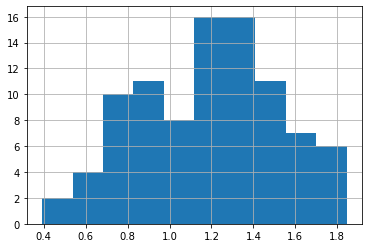

In [27]:
data.apply(volume_to_r).hist()

The volume forumula is 
$(4/3)\pi r^3$, so given the volume, we get $r$ as $((3/4\pi) V)^{1/3}$...

In [19]:
chull_volume.groupby(burgess.condition_cols).mean().apply(lambda V: np.power(3/4/np.pi*V, 1/3))

locus  genotype  meiosis
HET5   WT        t0         0.847339
                 t1         0.950871
                 t2         1.084229
                 t3         1.108406
                 t4         1.275806
                 t5         1.272207
                 ta         1.284811
LYS2   SP        t0         0.680312
                 t1         0.696057
                 t2         0.805385
                 t3         0.874531
                 t4         0.956748
                 t5         0.939411
                 t6         0.958558
       WT        t0         0.852138
                 t1         0.786381
                 t2         0.876471
                 t3         1.105162
                 t4         0.916134
                 t5         1.171249
                 t6         0.952502
URA3   SP        t0         0.794922
                 t1         0.933294
                 t2         1.087284
                 t3         1.142240
                 t4         1.176725
             

So realistically, we will want to call the radius 1.3$\mu{}m$.

## Supplemental Figure -- "Transient" (Un)paired Times

In [46]:
is_30 = interior_df.reset_index().set_index(['wait_state'] + burgess.condition_cols)
is_30 = is_30['wait_time'] == 30
p30 = is_30.groupby(['wait_state'] + burgess.condition_cols).agg(['mean', 'std', 'count'])
cell_count = interior_df.reset_index().groupby(['wait_state'] + condition_cols)['cell'].unique().apply(len)
p30['cell_count'] = cell_count
p30['ste'] = p30['std']/np.sqrt(p30['cell_count'])
def suppfig_6a(ax):
    plot_fracs_large(p30.loc['pair'], ax)
    ax.set_title('Fraction of interaction times that are fast')
    return ax
def suppfig_6b(ax):
    plot_fracs_large(p30.loc['unp'], ax)
    ax.set_title('Fraction of search times that are fast')


In [47]:
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = 'k' if genotype == 'WT' else 'r'
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 8  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            
            if ax is None:
                ax = plt
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chron. stage ($t_\#$)')
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  

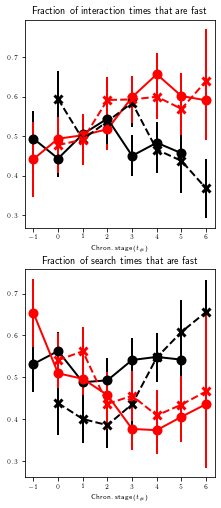

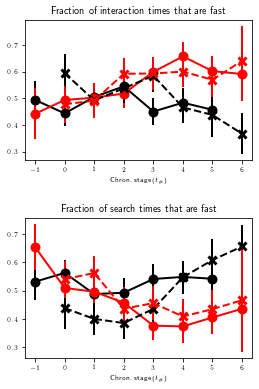

In [48]:
bplt.make_at_aspect([suppfig_6a, suppfig_6b], 2*[1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/SuppFig_p30.svg')

## Chromosome size vs CO count

In [56]:
chr_info = pd.DataFrame([[1, 230218, 2.2],
                         [2, 813184, 6.4],
                         [3, 316620, 3.4],
                         [4, 1531933, 10.2],
                         [5, 576874, 4.45],
                         [6, 270161, 2.65],
                         [7, 1090940, 8.25],
                         [8, 562643, 4.65],
                         [9, 439888, 3],
                         [10, 745751, 6.5],
                         [11, 666816, 5.25],
                         [12, 1078177, 8.65],
                         [13, 924431, 7.25],
                         [14, 784333, 6.4],
                         [15, 1091291, 7.75],
                         [16, 948066, 7.45],
                        ], columns = ['Chromosome', 'Length', 'COs'])

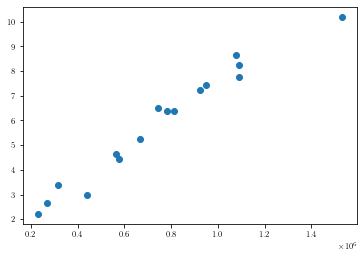

In [57]:
plt.scatter(chr_info['Length'], chr_info['COs'])

## Old color code

In [ ]:
## less old color code, but colormath is broken AF
# def bruno_div_map(n, left_lab, right_lab, midpoint_l, target_l=None):
#     illuminant = left_lab.illuminant
#     if illuminant != right_lab.illuminant:
#         raise ValueError("Must work with same illuminant!")
#     left_l = left_lab.lab_l if target_l is None else target_l
#     right_l = right_lab.lab_l if target_l is None else target_l
#     t = np.linspace(0, 1, n)
#     lab_a = np.interp(t, [0, 1], [left_lab.lab_a, right_lab.lab_a])
#     lab_b = np.interp(t, [0, 1], [left_lab.lab_b, right_lab.lab_b])
#     lab_l = np.interp(t, [0, 1/2, 1], [left_l, midpoint_l, right_l])
#     return [LabColor(lab_l[i], lab_a[i], lab_b[i]) for i in range(n)]




# # # OLD COLOR CODE
# # helper functions for makign color scheme
# def bruno_div_map(start_hue, start_sat, end_hue, end_sat, 
#                   target_lightness, interior_lightness, n):
#     # move linearly through hue space
#     hues = np.linspace(start_hue, end_hue, n)
    
#     # keep saturation constant on each side
#     sats = start_sat*np.ones_like(hues)
#     sats[int(n/2):] = end_sat
    
#     # lightness increase then decrease linearly
#     lights = np.ones_like(hues)
#     # +1 to peak lightness at odd center, if it exists
#     num_left = int(n/2) + 1 if n % 2 == 1 else int(n/2)
#     # run the following code to see that the lhs array indexers correctly split the array up
#     # for n in [4, 5]: # outputs 3,3 (half including middle) then 2,2 (half, no middle exists)
#     #     print(len(np.ones(n)[int(n/2):]))
#     #     print(len(np.ones(n)[:int(n/2)]))
#     lights[:num_left] = np.linspace(target_lightness, interior_lightness, num_left)
#     # to see that the 
#     lights[int(n/2):] = np.flip(lights[:num_left])
    

#     return np.array([hues, lights, sats]).T

# # colors we're interpolating between
# target_hues = [0.5609245293072375, 0.38810327170846054, 0.9319484879782322]
# target_saturations = [0.45, 0.35, 0.45]
# min_lightness = 0.4
# max_lightness = 0.7
# # before interpolating, useful to save actual values for later
# color_early, color_mid, color_late = [colorsys.hls_to_rgb(target_hues[i], target_saturations[i], min_lightness) for i in range(3)]
# blended_divs = np.concatenate((
#     bruno_div_map(target_hues[0], target_saturations[0],
#               target_hues[1], target_saturations[1],
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1500),
#     bruno_div_map(target_hues[1], target_saturations[1],
#               target_hues[2], target_saturations[2],
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1060)[1:]
# ))
# bgr = np.array([colorsys.hls_to_rgb(*hls) for hls in blended_divs])
# dark_blended_divs = np.concatenate((
#     bruno_div_map(target_hues[0], target_saturations[0]*0.7,
#               target_hues[1], target_saturations[1]*0.7,
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1500),
#     bruno_div_map(target_hues[1], target_saturations[1]*0.7,
#               target_hues[2], target_saturations[2]*0.7,
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1060)[1:]
# ))
# bgr_dark = np.array([colorsys.hls_to_rgb(*hls) for hls in dark_blended_divs])

## How to size multiple axes AND figure correctly

The final version:

In [96]:
plot_funcs = [fig4a, fig4b, fig4c]
halign = ['min_axis_width', 'min_axis_width', 'full']
heights = 1/golden_ratio
is_ratio = True
kw_figs = {}
hspace = None

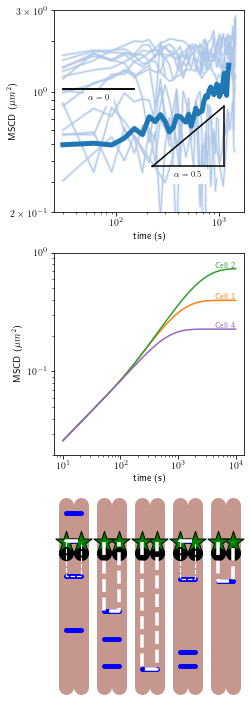

In [221]:
n_plots = len(plot_funcs)
halign = _ensure_seq(halign, n_plots, str, 'halign', 'plot_funcs')
heights = _ensure_seq(heights, n_plots, numbers.Number, 'heights', 'plot_funcs')
is_ratio = _ensure_seq(is_ratio, n_plots, bool, 'is_ratio', 'plot_funcs')
# first make "test" figure to get correct extents including all labels, etc
# leave a 2x margin of error for the labels, etc. to fit into vertically.
max_heights = heights.copy()
max_heights[is_ratio] = heights[is_ratio]*col_width
test_fig_height = 2*np.sum(max_heights)
fig, axs = plt.subplots(nrows=n_plots,
                        figsize=(col_width, test_fig_height),
                        **kw_figs)
if n_plots == 1:
    axs = [axs]  # not sure why the inconsistency in subplots interface...
for i in range(n_plots):
    plot_funcs[i](axs[i])


# plt.savefig('/home/bbeltr1/Downloads/test.svg')
    
# # "dry-run" a figure save to get "real" bbox for full figure with all
# # children
# fake_file = io.StringIO()
# fig.canvas = backend_svg.FigureCanvasSVG(fig)
# renderer = backend_svg.RendererSVG(col_width, test_fig_height, fake_file)
# _ = fig.draw(renderer)

disp_to_inch = fig.dpi_scale_trans.inverted()
fig_to_inch = fig.dpi_scale_trans.inverted() + fig.transFigure

<ipython-input-237-0217db1918e4>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/home/bbeltr1/.miniconda3/envs/burgess/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


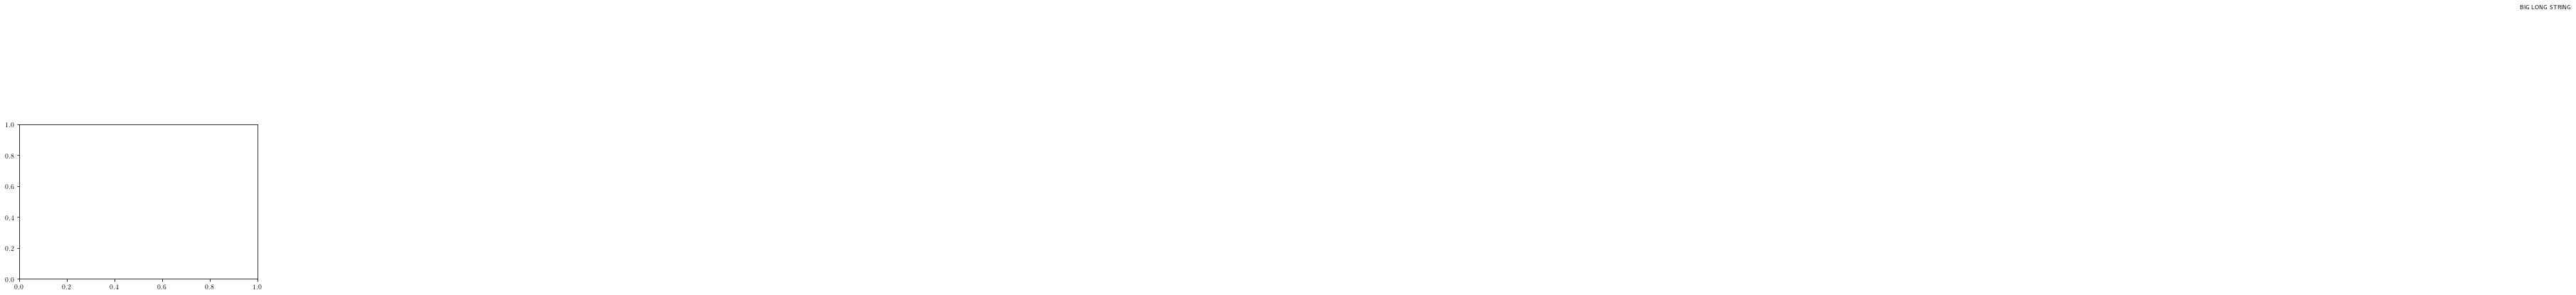

In [237]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

text = ax.annotate('BIG LONG STRING', xy=(1.25, 2), xytext=(10.5, 1.75), annotation_clip=False)
p1 = ax.get_position()
plt.tight_layout()
p2 = ax.get_position()

In [233]:
p1

Bbox([[0.125, 0.125], [0.9, 0.88]])

In [234]:
p2

Bbox([[0.125, 0.125], [0.9, 0.88]])

In [226]:
lines = ax.get_children()[:5]
lines

In [230]:
[line.get_window_extent(fig._cachedRenderer) for line in lines]

[Bbox([[39.28131818181818, 242.61685006312507], [212.0076818181818, 243.4842833780918]]),
 Bbox([[39.28131818181818, 369.83893399287376], [212.0076818181818, 510.10419667635927]]),
 Bbox([[39.28131818181818, 369.82544739982245], [212.0076818181818, 541.7455755892871]]),
 Bbox([[39.28131818181818, 295.8299867439022], [212.0076818181818, 298.66511143068897]]),
 Bbox([[39.28131818181818, 369.84570845641196], [212.0076818181818, 481.31590373819716]])]

In [229]:
lines[2].set_visible(False)

In [222]:
texts = ax.get_children()[5:10]
texts

[Text(10000.0, 0.0022649043724000746, 'Cell 0'),
 Text(10000.0, 0.39711517595289303, 'Cell 1'),
 Text(10000.0, 0.7331782089085989, 'Cell 2'),
 Text(10000.0, 0.006598578049607238, 'Cell 3'),
 Text(10000.0, 0.2273185728898662, 'Cell 4')]

BUG! matplotlib.text.Annotation needs to fix its "get_visible"

In [218]:
text = texts[0]

In [224]:
text.set_visible(False)

In [219]:
text.get_window_extent()

Bbox([[191.73619622703922, 243.4842833780918], [212.0076818181818, 250.5688308271111]])

In [225]:
bplt.print_bbox_from_arr(disp_to_inch.transform(text.get_window_extent()))

Bbox(xmin=0.0, xmax=0.013888888888888888,
     ymin=0.0, ymax=0.013888888888888888


In [220]:
bplt.print_bbox_from_arr(disp_to_inch.transform(text.get_window_extent()))

Bbox(xmin=2.6630027253755446, xmax=2.944551136363636,
     ymin=3.3817261580290525, ymax=3.480122650376543


In [200]:
bplt.print_bbox_from_arr(disp_to_inch.transform(ax.get_tightbbox(renderer)))

Bbox(xmin=-0.15960147041098058, xmax=3.0645,
     ymin=3.3817261580290525, ymax=7.792812233064607


In [145]:
max_y = fig_to_inch.transform([1, 1])[1]
ink_inches = [bbox.copy() for bbox in ax_inches]
for bbox in ink_inches:
    bbox[:,1] = (max_y - bbox[:,1])[::-1]
# for bbox in ink_inches:
#     bplt.print_bbox(bbox)
# for bbox in ink_inches:
#     bplt.print_extents_from_arr(bbox)

Bbox(xmin=0.425625, ymin=1.515172126819241,
     width=2.6388749999999996, height=2.8038111660503127)
Bbox(xmin=0.425625, ymin=4.879745526079616,
     width=2.6388749999999996, height=2.8038111660503127)
Bbox(xmin=0.425625, ymin=8.244318925339991,
     width=2.6388749999999996, height=2.8038111660503127)


In [146]:
max_y = fig_to_inch.transform([1, 1])[1]
ink_bbox_inches = [bbox.copy() for bbox in ax_bbox_inches]
for bbox in ink_bbox_inches:
    bbox[:,1] = (max_y - bbox[:,1])[::-1]
# for bbox in ink_inches:
#     bplt.print_bbox(bbox)
for bbox in ink_bbox_inches:
    bplt.print_extents_from_arr(bbox)

Bbox(xmin=-0.22805950497861763, ymin=1.4637606489262822,
     width=3.2925595049786174, height=3.2589113294120446)
Bbox(xmin=-0.15960147041098058, ymin=4.833622157095739,
     width=3.2241014704109805, height=4.411086075035556)
Bbox(xmin=0.425625, ymin=8.244318925339991,
     width=2.6388749999999996, height=2.8038111660503127)


In [144]:
importlib.reload(bplt)

<module 'bruno_util.plotting' from '/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py'>

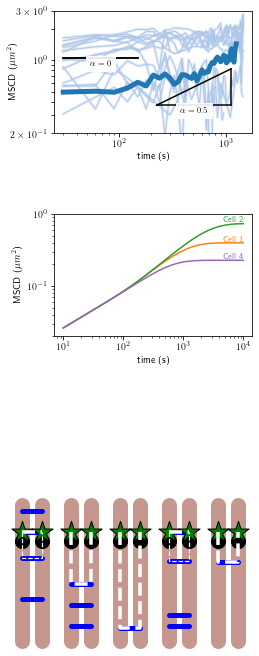

In [114]:
# now get extents of axes themselves and axis "bbox"s (i.e. including
# labels, etc)
ax_bbox_inches = []
ax_inches = []
for ax in axs:
    # get_tightbbox docs say in "figure pixels", but means "display"
    ax_bbox = ax.get_tightbbox(renderer)
    ax_bbox_inches.append(disp_to_inch.transform(ax_bbox))
    ax_inches.append(fig_to_inch.transform(ax.get_position()))
x0s, y0s, x1s, y1s = map(np.array, zip(
    *map(np.ndarray.flatten, ax_bbox_inches)
))
ax0s, ay0s, ax1s, ay1s = map(np.array, zip(
    *map(np.ndarray.flatten, ax_inches)
))

# calculate space required in addition to axes themselves
pads_left = ax0s - x0s
pads_right = x1s - ax1s
pads_above = y1s - ay1s
pads_below = ay0s - y0s
max_pad_left = np.max(pads_left)
max_pad_right = np.max(pads_right)

# get axes sizes
x0 = np.zeros(n_plots)
x1 = np.zeros(n_plots)
for i in range(n_plots):
    if halign[i] == 'full':
        x0[i] = pads_left[i]
        x1[i] = col_width - pads_right[i]
    elif halign[i] == 'min_axis_width':
        x0[i] = max_pad_left
        x1[i] = col_width - max_pad_right
    else:
        raise ValueError(f"Invalid option passed for halign: {halign[i]}. "
                          "Should be 'full' or 'min_axis_width'")
real_heights = heights.copy()
real_heights[is_ratio] = heights[is_ratio]*(x1 - x0)[is_ratio]
if hspace is None:
    hspace = fig.subplotpars.hspace
hspace = hspace*np.mean(real_heights)

# make new figure with axes "correctly" located
total_height = np.sum(real_heights) + np.sum(pads_below) \
        + np.sum(pads_above) + (n_plots - 1)*hspace
fig = plt.figure(figsize=(col_width, total_height), **kw_figs)
cur_y = 1 # track y pos normalized to height of figure
for i in range(n_plots):
    left = x0[i]/col_width
    right = x1[i]/col_width
    cur_y -= pads_above[i]/total_height
    top = cur_y
    cur_y -= real_heights[i]/total_height
    bottom = cur_y
    cur_y -= pads_below[i]/total_height
    cur_y -= hspace/total_height
    #TODO if right - left < 0, or top - bottom < 0, complain that an
    # annotation that has been requested doesn't fit in the column
    # absolutely
    ax = fig.add_axes([left, bottom, right - left, top-bottom])
    plot_funcs[i](ax)

Of course, the total width of the figure is set by the column width (which you should extract from LaTeX, as seen on `https://www.bastibl.net/publication-quality-plots/`_.

For example you could use the following code, where `placeholder.pdf` is any old image file (`.jpg`/`.png` will also work)::

    \begin{figure}
        \includegraphics[width=\columnwidth]{placeholder}
        \caption{This is a placeholder to measure the width of a plot. Its with is set to \texttt{columnwidth}.}
    \end{figure}
    
if you then open this file in Illustrator or Inkscape, you can extract the real width (in inches) of this placeholder to get `col_width`, which we will be expressing everything else here in terms of. 



Now, you have to specify the aspect ratio of each actual axis in your figure. For images, for example, you can grab the aspect ratio from the image object:

In [63]:
im = Image.open('extracted-progression-diagram.png')
im_height_ratio = im.height/im.width
im_height_ratio

0.2842430484037075

once you have all the ratios, you might think you can just do this:

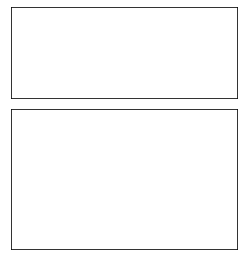

In [69]:
# figure size parameterization
text_space = 0.0*col_width
ax_height_1a = 0.4*col_width
spacing = 0.05*col_width
ax_height_1b = (1/golden_ratio)*col_width
fig_height = text_space + ax_height_1a + spacing + ax_height_1b
fig1 = plt.figure(figsize=(col_width,fig_height))
# [left, bottom, width, height]
ax1a = fig1.add_axes([0, (ax_height_1b+spacing)/fig_height, 1, ax_height_1a/fig_height],
                     xticks=[], yticks=[])
# ax1a.axis('off')
ax1b = fig1.add_axes([0, 0, 1, ax_height_1b/fig_height],
                     xticks=[], yticks=[])


or more in general

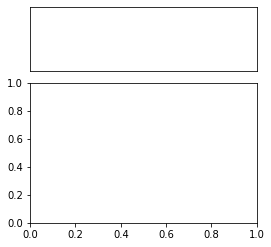

In [81]:
# col_width = # set above
intended_ratios = [im_height_ratio, 1/golden_ratio]
ax_args = [{'frameon': True, 'xticks': [], 'yticks': []}, {}]
spacing_ratio = 0.05
# the final bboxes we want for each axis object (complete with its labels/annotations)
super_ax_bboxs = []
total_ratio = np.sum(intended_ratios) + spacing_ratio*(len(intended_ratios) - 1)
cur_y = total_ratio
for height_ratio in intended_ratios:
    cur_y -= height_ratio
    super_ax_bboxs.append([0, cur_y/total_ratio, 1, height_ratio/total_ratio])
    cur_y -= spacing_ratio

fig = plt.figure(figsize=(col_width, col_width*total_ratio))
axs = [fig.add_axes(bbox, **ax_args[i]) for i, bbox in enumerate(super_ax_bboxs)]

plt.savefig('/home/bbeltr1/Downloads/ax_spacing.pdf')

getting the extents of these axes boxes in inkscape gives

In [71]:
bbox_a = [0, 201.933, 302.281, 201.933+85.922]
bbox_b = [0, 0.001, 302.281, 186.818]

In [72]:
intended_ratios

[0.2842430484037075, 0.6180339887498948]

In [73]:
85.922/302.281

0.2842454537334467

In [74]:
186.818/302.281

0.6180275968387031

so the axes are the right size, and I'm getting the correct amount of whitespace in between them "real" figure size (where the extra width measured in illustrator is because the ticks survive even though they go off the page)

In [75]:
bbox_actual = [-4.667, 0.001, 306.948, 288.388]

In [77]:
fig_height/col_width

1.0680339887498949

In [78]:
306.948/302.281

1.0154392766994949

but while these axes have the right aspect ratio right now, as soon as we add ticks or annotations, they will overflow over the edge of our figure. 

Fine, what if we ignore this for now and make the full figure?

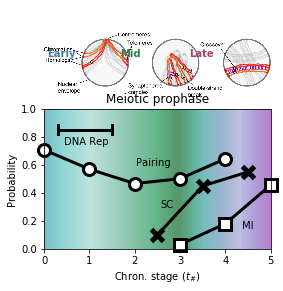

In [107]:
# col_width = # set above
intended_ratios = [im_height_ratio, 1/golden_ratio]
ax_args = [{'frameon': False, 'xticks': [], 'yticks': []}, {}]
spacing_ratio = 0.05
# the final bboxes we want for each axis object (complete with its labels/annotations)
super_ax_bboxs = []
total_ratio = np.sum(intended_ratios) + spacing_ratio*(len(intended_ratios) - 1)
cur_y = total_ratio
for height_ratio in intended_ratios:
    cur_y -= height_ratio
    super_ax_bboxs.append([0, cur_y/total_ratio, 1, height_ratio/total_ratio])
    cur_y -= spacing_ratio

fig = plt.figure(figsize=(col_width, col_width*total_ratio))
axs = [fig.add_axes(bbox, **ax_args[i]) for i, bbox in enumerate(super_ax_bboxs)]

fig1a(axs[0])
fig1b(axs[1])

plt.subplots_adjust()

plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-02-25-pnas/fig1-meiotic-progression.pdf', dpi=300, bbox_inches='tight')

This "looks" correct. And the aspect ratios we requested are there. However, instead of shrinking the axes to make it fig in the originally requested `figsize`, matplotlib simply increases the figure `bbox` to larger than we had originally requested. If we tried to use this figure, we'd have to shrink it to make it fit! (which would mean our carefully chosen text sizes wouldn't match anymore!)

Removing `bbox_inches='tight'` leaves us with the xticks cut off instead, even if we call `subplots_adjust` (since we didn't use subplots). If we want heterogeneously-spaced subplots, we're going to have to place and size them correctly ourselves....

.. warning::
    
    the following plot APPEARS correct when made in Jupyter (presumedly due to some `%matplotlib inline` magic, where bbox_layout='tight' is automatically used before saving to tmp file before displaying figure in notebook), but when saved by us, this figure is, in fact, cut off.

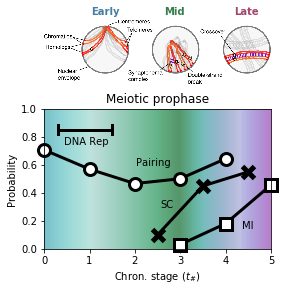

In [143]:
# figure size parameterization
text_space = 0.0*col_width
ax_height_1a = 0.4*col_width
spacing = 0.05*col_width
ax_height_1b = (1/golden_ratio)*col_width
fig_height = text_space + ax_height_1a + spacing + ax_height_1b
fig1 = plt.figure(figsize=(col_width,fig_height))
# [left, bottom, width, height]
ax1a = fig1.add_axes([0, (ax_height_1b+spacing)/fig_height, 1, ax_height_1a/fig_height],
                     frameon=False, xticks=[], yticks=[])
# ax1a.axis('off')
ax1b = fig1.add_axes([0, 0, 1, ax_height_1b/fig_height])

fig1a(ax1a)
fig1b(ax1b)

plt.subplots_adjust()
plt.savefig('/home/bbeltr1/Downloads/test-sp-adjust.pdf', dpi=300)

This is not what we want. I've previously used `plt.tight_layout()` with great success. However, this and `bbox_inches='tight'` are not equivalent. The former scales axes down to fit in figure box, while the latter scales figure up.

So what we really want is to use the subplots interface (intead of adding axes manually) so that we can just call `plt.tight_layout()`.

Thankfully, apparently there's a hidden gem: `Gridspec <https://matplotlib.org/3.1.1/tutorials/intermediate/gridspec.html>`_ that makes the subplots interface actually flexible enough to be useful!

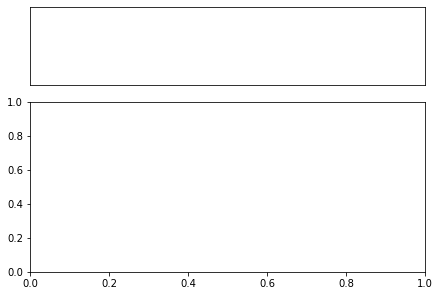

In [139]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_aspect = im.height/im.width

fig1 = plt.figure(constrained_layout=True)
# absolute size doesn't matter, only ratio
widths = [1]
heights = [im_aspect, 1/golden_ratio]
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


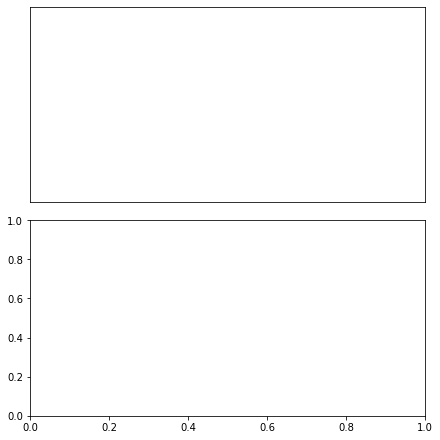

In [158]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_aspect = im.height/im.width

fig1 = plt.figure(constrained_layout=True, figsize=(6,6))
# absolute size doesn't matter, only ratio
widths = [1]
# heights = [im_aspect, 1]
heights = [1, 1]
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


# fig1a(ax1a)
# fig1b(ax1b)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

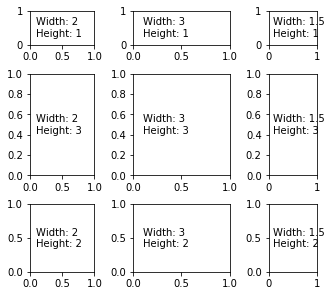

In [13]:
fig5 = plt.figure(constrained_layout=True)
widths = [2, 3, 1.5]
heights = [1, 3, 2]
spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
for row in range(3):
    for col in range(3):
        ax = fig5.add_subplot(spec5[row, col])
        label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')
plt.savefig('/home/bbeltr1/Downloads/test.pdf')

In [6]:
def example_plot(ax, fontsize=12, nodec=False):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    if not nodec:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')


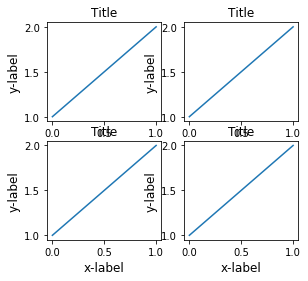

In [11]:
fig, axs = plt.subplots(2, 2, constrained_layout=False)
for ax in axs.flat:
    example_plot(ax)

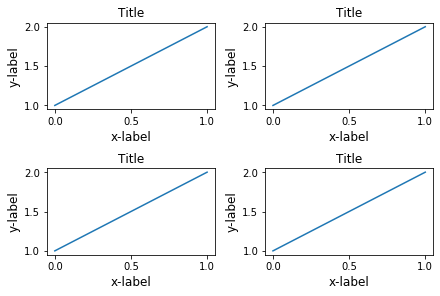

In [15]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
for ax in axs.flat:
    example_plot(ax)

In [106]:
# crap, looks like tutorial does this to misleading make it look better than it actually is at conserving aspect ratio

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np


plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 6, 4



fuck. nope. doesn't preserve aspect ratio.....

looks like I have to write my own engine to make figure logically remain in correct orientation given fixed width(/height) constraint!!!

it seems like vaguely, what we want to do, is to make our plot (independently of final figure size), then figure out what the axes extents are in that (oversized) figure w.r.t. to the final figure size, to account for text/labels/etc., then go back and remake figure with that information in hand.....

of course when we go back and remake the figure with "smaller" axes, the text will stay the same absolute size (so will be larger relative to the axes), and we may have to repeat this process to converge on the correct axes sizes :/....

If i were implemneting this in mainline, maybe I would call it `constrained_layout='horizontal'` or something.

In [47]:
orig_canvas = fig1.canvas
fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                      orientation='portrait', dryrun=True)
renderer = fig1._cachedRenderer
bbox_inches = fig1.get_tightbbox(renderer)

In [103]:
fig1.get_tightbbox?

In [61]:
bbox_inches.bounds

(-0.5080295138888888,
 -0.43988715277777773,
 3.7401228472222217,
 3.8028698551938964)

In [90]:
fig1.axes[0].get_position()

Bbox([[0.0, 0.6254800837675687], [1.0, 0.9999999999999999]])

In [99]:
fig1.transFigure.transform(fig1.axes[0].get_position())

array([[  0.        , 151.45046657],
       [226.71072   , 242.13475457]])

In [105]:
fig1.bbox.bounds

(0.0, 0.0, 226.71071999999998, 242.13475457396055)

In [104]:
fig1.bbox_inches.bounds

(0.0, 0.0, 3.14876, 3.3629827024161187)

cool, figured out how to get this stupid thing to give me reasonable bbox that I can compare to the axes positions

In [64]:
plt.figure?

but wait, have even more clever strategy now. 

First, make figure with constrained axes as above. won't work, but all we care about is how much space we have between axes (which doesn't depend on aspect ratio) and the absolute width of the axes. then we can use these to set the aspect ratio ourselves.

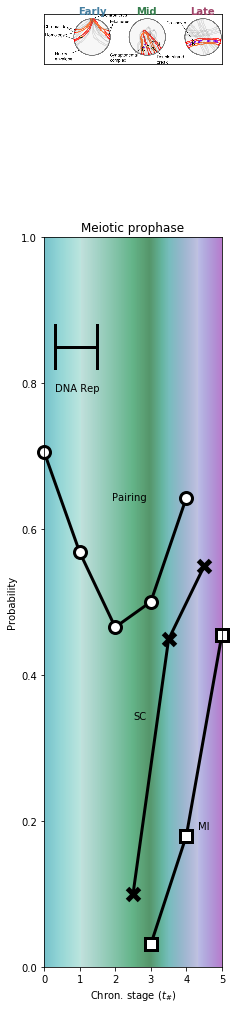

In [148]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

fig1 = plt.figure(constrained_layout=True, figsize=(col_width,  5*col_width))
# absolute size doesn't matter, only ratio
widths = [1]
heights = intended_ratios
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


fig1a(ax1a)
fig1b(ax1b)

# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

gotta be careful with constrained_layout for this, cause it may adjust the width in ways I don't understand depending in initial ("test") figure size

/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:27: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/home/bbeltr1/.miniconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


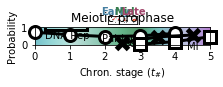

In [150]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

fig1 = plt.figure(constrained_layout=True, figsize=(col_width,  col_width/6))
# absolute size doesn't matter, only ratio
widths = [1]
heights = intended_ratios
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


fig1a(ax1a)
fig1b(ax1b)

# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

instead, use regular subplots...just make sure to leave more than enough room to get max possible width for each figure

In [128]:
plt.subplots?

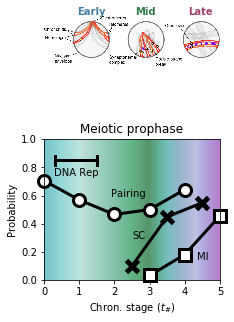

In [7]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

# leave a 2x margin of error for extra labels, etc.
test_fig_height = 2*np.sum(intended_ratios)*col_width

fig1, (ax1a, ax1b) = plt.subplots(nrows=2, figsize=(col_width, test_fig_height))
ax1a.axis('off')

fig1a(ax1a)
fig1b(ax1b)


# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

In [196]:
# in figure "inches" units (fig.dpi_scale_trans)
fig1.get_tightbbox(fig1.canvas.renderer).bounds

(-0.11855777777777783,
 0.2241523497658336,
 3.035775111111111,
 4.252129113085017)

In [197]:
# in "figure pixel" units....is this IdentityTransform??...assume so for now
ax1a.get_tightbbox(fig1.canvas.renderer)

Bbox([[28.338839999999998, 264.84761871599244], [204.039648, 322.2922653252612]])

In [156]:
# in "figure" units (0,1) (fig.transFigure)
ax1a.get_position()

Bbox([[0.125, 0.647372304688804], [0.9, 0.769445877129378]])

seems like this is in display units....

In [159]:
fig1.transFigure.inverted().transform(ax1a.get_tightbbox(renderer))

array([[0.125     , 0.6473723 ],
       [0.9       , 0.78717432]])

In [160]:
fig1.dpi_scale_trans.inverted().transform(ax1a.get_tightbbox(renderer))

array([[0.393595  , 3.67843915],
       [2.833884  , 4.47280924]])

In [162]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform(ax1a.get_position())
)

array([[0.393595  , 3.67843915],
       [2.833884  , 4.37207433]])

In [166]:
Out[162][1] - Out[162][0]

array([2.440289  , 0.69363518])

In [167]:
Out[160][1] - Out[160][0]

array([2.440289  , 0.79437009])

In [168]:
fig1.dpi_scale_trans.inverted().transform(ax1b.get_tightbbox(renderer))

array([[-0.11443451,  0.27037631],
       [ 2.91721733,  2.87032895]])

In [169]:
Out[168][1] - Out[168][0]

array([3.03165185, 2.59995264])

In [172]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform([1,1])
)

array([3.14876   , 5.68210769])

In [182]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform(ax1b.get_position())
)

array([[0.393595  , 0.71026346],
       [2.833884  , 2.66025951]])

In [191]:
t = fig1.dpi_scale_trans.inverted() + fig1.transFigure

In [192]:
t.transform(ax1b.get_position())

array([[0.393595  , 0.71026346],
       [2.833884  , 2.66025951]])

In [183]:
Out[182][0,0] - (-0.11443451388888894)

0.5080295138888888

In [186]:
ax1b.get_axes_locator() is None

True

In [198]:
[t.transform(ax.get_position()) for ax in fig1.axes]

[array([[0.393595  , 3.67843915],
        [2.833884  , 4.37207433]]), array([[0.393595  , 0.71026346],
        [2.833884  , 2.66025951]])]

In [200]:
[fig1.dpi_scale_trans.inverted().transform(ax.get_tightbbox(fig1.canvas.renderer)) for ax in fig1.axes]


[array([[0.393595  , 3.67843915],
        [2.833884  , 4.47628146]]), array([[-0.11855778,  0.22415235],
        [ 2.91721733,  2.88248173]])]

In [201]:
fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                      orientation='portrait', dryrun=True)
renderer = fig1._cachedRenderer

In [202]:
[fig1.dpi_scale_trans.inverted().transform(ax.get_tightbbox(renderer)) for ax in fig1.axes]


[array([[0.393595  , 3.67843915],
        [2.833884  , 4.47280924]]), array([[-0.11443451,  0.27037631],
        [ 2.91721733,  2.87032895]])]

okay, now the generalized code

In [5]:
import numbers
import io
def make_at_aspect(plot_funcs, height_ratios, col_width,  tight_width='bbox', hspace=None, halign=None, **kw_figs):
    """Get figure with fixed column width and requested aspect ratios per subplot.
    
    Parameters
    ----------
    plot_funcs : Sequence[Callable[[matplotlib.axes.Axes], None]]
        function to create each subplot given the axes to draw it into
    height_ratios : Sequence[float]
        height/width ratio desired for each subplot. single number is allowed for
        fixed aspect ratio across all axes
    col_width : float
        absolute width of figure desired, in inches
    tight_width : string
        'bbox' or 'tight'. 'bbox' means use default generated by bbox_inches='tight'. 'tight' 
        means to actually remove all whitespace from left and right size of final figure
    hspace : float
        vertical space between adjacent axes bboxes as fraction of average axis height 
        (not fraction of average axis bbox height). defaults to value in rc.
    halign : Sequence[string]
        either 'full' or 'min_axis_width' for each subplot. defaults to all 'min_axis_width'
    
    
    Returns
    -------
    ax : matplotlib.figure.Figure
        the final figure
        
    Notes
    -----
    No extra "axes_kw" argument is provided, since each axis is passed to it's appropriate 
    plot_func, which should be able to set any relevant extra parameters for that axis.
    """
    n_plots = len(plot_funcs)
    if halign is None:
        halign = n_plots * ['min_axis_width']
    try:
        if n_plots != len(height_ratios):
            raise ValueError("length of height_ratios and plot_funcs should match")
    except TypeError: # no __len__
        if not isinstance(height_ratios, numbers.Number):
            raise ValueError("height_ratios should be list of ratios or single float")
        # we have a single number, simply tile it accordingly
        height_ratios = n_plots*[height]
    
    # first make "test" figure to get correct extents including all labels, etc
    # leave a 2x margin of error for the labels to fit into vertically.
    test_fig_height = 2*np.sum(height_ratios)*col_width
    fig, axs = plt.subplots(nrows=n_plots, figsize=(col_width, test_fig_height), **kw_figs)
    for i in range(n_plots):
        plot_funcs[i](axs[i])
    
    # "dry-run" a figure save to get "real" bbox for full figure with all children
    fig.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig)
    preprint = fig.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                          orientation='portrait', dryrun=True)
    #TODO: which is right? neither seem exactly right according to inkscape?
    # if we use fig.canvas.renderer instead, we get different answers o.o
    renderer = fig._cachedRenderer
    disp_to_inch = fig.dpi_scale_trans.inverted()
    fig_to_inch = fig.dpi_scale_trans.inverted() + fig.transFigure

    # now get extents of axes themselves and axis "bbox"s (i.e. including labels, etc)
    ax_bbox_inches = []
    ax_inches = []
    for ax in axs:
        ax_bbox = ax.get_tightbbox(renderer) # docs say in "figure pixels", but means "display"
        ax_bbox_inches.append(disp_to_inch.transform(ax_bbox))
        ax_inches.append(fig_to_inch.transform(ax.get_position())) 
    x0s, y0s, x1s, y1s = map(np.array, zip(*map(np.ndarray.flatten, ax_bbox_inches)))
    ax0s, ay0s, ax1s, ay1s = map(np.array, zip(*map(np.ndarray.flatten, ax_inches)))
  
    # get final horizontal size of figure
    if tight_width == 'bbox':
        bbox_inches = fig.get_tightbbox(renderer).bounds
        real_h_extents = [bbox_inches[0], bbox_inches[2]]
        real_v_extents = [bbox_inches[1], bbox_inches[3]]
    elif tight_width == 'tight':
        real_h_extents = [np.min(x0s), np.max(x1s)]
        real_v_extents = [np.min(y0s), np.max(y1s)]
    
    # calculate space required in addition to axes themselves
    pads_left = ax0s - x0s
    pads_right = x1s - ax1s
    pads_above = y1s - ay1s
    pads_below = ay0s - y0s
    max_pad_left = np.max(pads_left)
    max_pad_right = np.max(pads_right)
    
    # get axes sizes
    x0 = np.zeros(n_plots)
    x1 = np.zeros(n_plots)
    height = np.zeros(n_plots)
    for i in range(n_plots):
        if halign[i] == 'full':
            x0[i] = pads_left[i]
            x1[i] = col_width - pads_right[i]
        elif halign[i] == 'min_axis_width':
            x0[i] = max_pad_left
            x1[i] = col_width - max_pad_right
        else:
            raise ValueError(f"Invalid option passed for halign: {halign[i]}. Should be 'full' or 'min_axis_width'")
    height = height_ratios*(x1 - x0)
    if hspace is None:
        hspace = fig.subplotpars.hspace
    hspace = hspace*np.mean(height)
    
    # make new figure with axes "correctly" located
    total_height = np.sum(height) + np.sum(pads_below) + np.sum(pads_above) \
                + (n_plots - 1)*hspace
    fig = plt.figure(figsize=(col_width, total_height), **kw_figs)
    cur_y = 1 # track y pos normalized to height of figure
    for i in range(n_plots):
        left = x0[i]/col_width
        right = x1[i]/col_width
        cur_y -= pads_above[i]/total_height
        top = cur_y 
        cur_y -= height[i]/total_height
        bottom = cur_y
        cur_y -= pads_below[i]/total_height
        cur_y -= hspace/total_height
        ax = fig.add_axes([left, bottom, right-left, top-bottom])
        plot_funcs[i](ax)
#     import pdb; pdb.set_trace()
    return fig            

#NOTE: alternate bbox from pixels to inches:
# bbox_inches = TransformedBbox(bbox, Affine2D().scale(1 / fig.dpi)

In [1]:
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
fig = make_at_aspect([fig1a, fig1b], [im_height_ratio, 1/golden_ratio], col_width,
                     tight_width='bbox', hspace=0.2, halign=['full', 'min_axis_width'])
plt.savefig('/home/bbeltr1/Downloads/test.pdf', dpi=300)

NameError: name 'Image' is not defined

cool, so that works, but requires a PR to matplotlib's upstream so that get_tightbbox works correctly

let's test that PR.

## Two particles vs one?

In [35]:
import numpy as np
import pandas as pd
from multi_locus_analysis.stats import pos_to_all_vel
num_time_points = 50
num_polymers = 1000
x = np.random.normal(size=(num_time_points, num_polymers))
x = np.cumsum(x, axis=0)
y = np.random.normal(size=(num_time_points, num_polymers))
y = np.cumsum(y, axis=0)
x = x - y

In [36]:
traj = np.arange(num_polymers)
traj = traj[None, :] + np.zeros_like(x)
t = np.arange(num_time_points)
t = t[:, None] + np.zeros_like(x)

In [37]:
df = pd.DataFrame.from_dict({'x': x.flatten(), 'traj': traj.flatten(), 't': t.flatten()})

In [38]:
vels = df.groupby('traj').apply(pos_to_all_vel, xcol='x', ycol=None, zcol=None, framecol='t')

/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:122: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ti = t[:,None] - np.zeros_like(t)[None,:]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:123: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tf = t[None,:] - np.zeros_like(t)[:,None]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:129: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  vs = {'v' + col: x[None,:] - x[:,None] for col, x in xs.items()}


In [39]:
vels.groupby('delta')['vx'].apply(lambda S: (S**2).mean())

delta
0.0      0.000000
1.0      1.989816
2.0      3.980748
3.0      5.973168
4.0      7.985148
5.0      9.976294
6.0     11.975873
7.0     13.946765
8.0     15.901597
9.0     17.858970
10.0    19.792084
11.0    21.716648
12.0    23.633833
13.0    25.565717
14.0    27.462708
15.0    29.359628
16.0    31.217277
17.0    33.079429
18.0    34.966311
19.0    36.852112
20.0    38.782620
21.0    40.741036
22.0    42.713619
23.0    44.684574
24.0    46.641450
25.0    48.608876
26.0    50.667845
27.0    52.736930
28.0    54.836439
29.0    56.980073
30.0    59.014881
31.0    61.016676
32.0    63.009342
33.0    65.001347
34.0    66.955974
35.0    68.886405
36.0    70.898552
37.0    72.860550
38.0    74.943092
39.0    76.983795
40.0    79.135038
41.0    81.045724
42.0    82.951621
43.0    84.969815
44.0    86.762573
45.0    88.621200
46.0    90.268609
47.0    91.976269
48.0    93.319416
49.0    95.074069
Name: vx, dtype: float64